In [46]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score)
from sklearn.metrics import (
    mean_absolute_error, mean_absolute_percentage_error,
    root_mean_squared_error)

import re
from typing import Literal

from itertools import product

# Датасеты


## Датасет для классификации


Для классификации будет использоваться
[датасет](https://www.kaggle.com/datasets/rabieelkharoua/consumer-electronics-sales-dataset)
для прогнозирования продаж электроники.

In [47]:
classification_df = pd.read_csv("data/consumer_electronics_sales_data.csv")
classification_df

,ProductID,ProductCategory,ProductBrand,ProductPrice,CustomerAge,CustomerGender,PurchaseFrequency,CustomerSatisfaction,PurchaseIntent
0,5874,Smartphones,Other Brands,312.949668,18,0,2,1,0
1,5875,Smart Watches,Samsung,980.389404,35,1,7,2,1
2,5876,Tablets,Samsung,2606.718293,63,0,1,5,1
3,5877,Smartphones,Samsung,870.395450,63,1,10,3,1
4,5878,Tablets,Sony,1798.955875,57,0,17,3,0
...,...,...,...,...,...,...,...,...,...
8995,14869,Smart Watches,Samsung,1041.149163,36,1,16,4,0
8996,14870,Smartphones,Samsung,1485.694311,57,0,5,1,1
8997,14871,Headphones,Samsung,2887.369597,28,0,18,4,0
8998,14872,Tablets,HP,1490.453964,38,0,4,2,1


Features:

- ProductID: уникальный идентификатор для каждого продукта.
- ProductCategory: категория продукта бытовой электроники (например, смартфоны, ноутбуки).
- ProductBrand: торговая марка продукта (например, Apple, Samsung).
- ProductPrice: цена товара ($).
- CustomerAge: возраст покупателя.
- CustomerGender: пол покупателя (0 - Мужчина, 1 - женщина).
- PurchaseFrequency: среднее количество покупок в год.
- CustomerSatisfaction: рейтинг удовлетворенности клиентов (от 1 до 5).
- PurchaseIntent (Target Variable): намерение совершить покупку.

In [48]:
classification_df.describe()

,ProductID,ProductPrice,CustomerAge,CustomerGender,PurchaseFrequency,CustomerSatisfaction,PurchaseIntent
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,10373.500000,1527.429195,43.347000,0.508889,10.054667,2.996000,0.566444
std,2598.220545,829.900898,15.055084,0.499949,5.461328,1.405301,0.495593
min,5874.000000,100.376358,18.000000,0.000000,1.000000,1.000000,0.000000
25%,8123.750000,809.165014,30.000000,0.000000,5.000000,2.000000,0.000000
50%,10373.500000,1513.024577,43.000000,1.000000,10.000000,3.000000,1.000000
75%,12623.250000,2244.415520,56.000000,1.000000,15.000000,4.000000,1.000000
max,14873.000000,2999.852253,69.000000,1.000000,19.000000,5.000000,1.000000


### Метрика

**F1-score** выбран как основная метрика, потому что наша задача - предсказать покупателей электроники (класс 1) при небольшом дисбалансе классов (~56% покупателей).

$$ F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall} $$

Простая точность (Accuracy) может быть обманчиво высокой, если модель чаще предсказывает непокупателей. F1-score учитывает и полноту (Recall), показывая, сколько реальных покупателей мы смогли найти, и точность (Precision), отражая, насколько предсказанные покупатели действительно купят.

## Датасет для регрессии

Для регрессии будет использоваться
[датасет](https://www.kaggle.com/datasets/muhammetvarl/laptop-price)
для прогнозирования цены ноутбука по его характеристикам.

In [49]:
regression_df = pd.read_csv("data/laptop_price.csv", encoding='latin1')
regression_df

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,1316,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,14.0,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.8kg,638.00
1299,1317,Lenovo,Yoga 900-13ISK,2 in 1 Convertible,13.3,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 520,Windows 10,1.3kg,1499.00
1300,1318,Lenovo,IdeaPad 100S-14IBR,Notebook,14.0,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5kg,229.00
1301,1319,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,764.00


Features:

- Company: Производитель ноутбуков
- Product: Марка и модель
- TypeName: Тип (Ноутбук, Ультрабук, игровой и т.д.)
- Inches: Размер экрана
- ScreenResolution: Разрешение экрана
- Cpu: Центральный процессор (CPU)
- Ram: ОЗУ ноутбука
- Memory: Жесткий диск / SSD-накопитель
- GPU: Графические процессоры (GPU)
- OpSys: Операционная система
- Weight: Вес ноутбука
- Price_euros: Цена (Евро)

In [50]:
regression_df.describe()

,laptop_ID,Inches,Price_euros
count,1303.000000,1303.000000,1303.000000
mean,660.155794,15.017191,1123.686992
std,381.172104,1.426304,699.009043
min,1.000000,10.100000,174.000000
25%,331.500000,14.000000,599.000000
50%,659.000000,15.600000,977.000000
75%,990.500000,15.600000,1487.880000
max,1320.000000,18.400000,6099.000000


Для оценки точности прогноза цены ноутбука используется
**MAE (Mean Absolute Error)**, так как она показывает
среднее абсолютное отклонение предсказанной цены от реальной в евро,
легко интерпретируется и устойчива к выбросам.

$$ MAE = \frac{1}{n} \cdot \Sigma^n_{i = 1} | y_i - \hat{y_i} | $$

# Baseline

## Классификация

### Создание baseline

Используется алгоритм KNN для задачи классификации

Разделение датасета на `train` и `test`

In [51]:
cX = classification_df.drop(columns=["ProductID", "PurchaseIntent"])
cy = classification_df["PurchaseIntent"]

cX_train, cX_test, cy_train, cy_test = train_test_split(
    cX, cy, test_size=0.2, random_state=42
)

Препроцессинг данных

In [52]:
cat_cols = ["ProductCategory", "ProductBrand"]
num_cols = ["ProductPrice",
            "CustomerAge",
            "PurchaseFrequency",
            "CustomerSatisfaction"]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols),
])

cX_train_scaled = preprocessor.fit_transform(cX_train)
cX_test_scaled = preprocessor.transform(cX_test)

Создание и обучение модели

In [53]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(cX_train_scaled, cy_train)
cy_pred = knn.predict(cX_test_scaled)

Оценка качества модели

In [54]:
f1 = f1_score(cy_test, cy_pred)
print(f"""
F1 Score:   {f1}
==============================
Accuracy:   {accuracy_score(cy_test, cy_pred)}
Precision:  {precision_score(cy_test, cy_pred)}
Recall:     {recall_score(cy_test, cy_pred)}
""")


F1 Score:   0.7219796215429404
Accuracy:   0.6816666666666666
Precision:  0.7058823529411765
Recall:     0.7388282025819265



### Улучшение baseline

Построение матрицы корреляции

<Axes: >

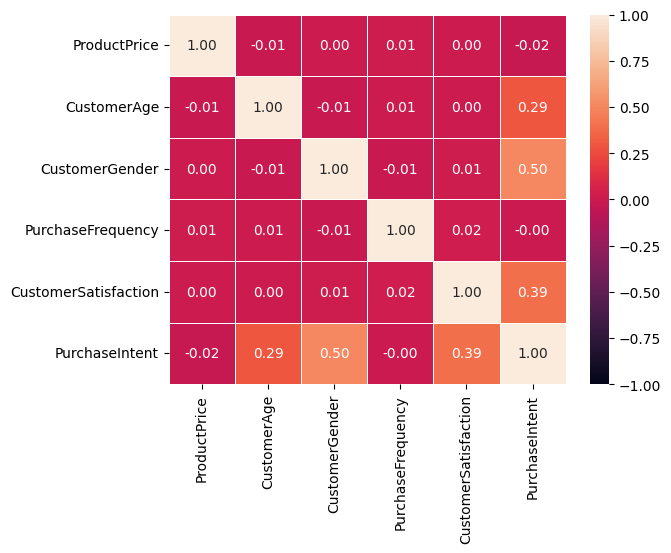

In [55]:
corr_matrix = classification_df.drop(columns=cat_cols+["ProductID"]).corr()
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    vmin=-1, vmax=1,
    linewidths=0.5
)


Можно заметить, что больше всего на `PurchaseIntent` влияют признаки `CustomerGender`, `CustomerAge` и `CustomerSatisfaction`.

Проверим сбалансированность классов

In [56]:
classification_df["PurchaseIntent"].value_counts()

PurchaseIntent
1    5098
0    3902
Name: count, dtype: int64

Примерно 56.6% к 43.4%. Для бинарной классификации такой перекос считается умеренным, а не проблемным.

Выбросы среди данных отсутствуют:

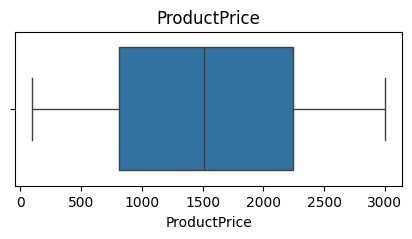

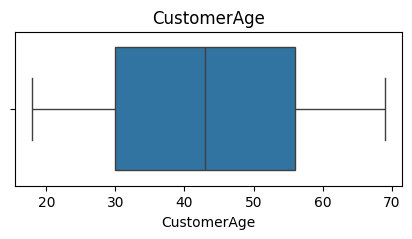

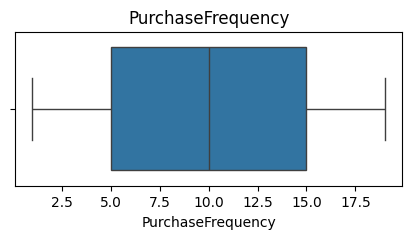

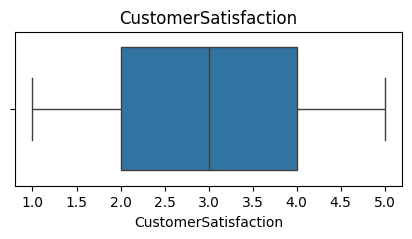

In [57]:
for col in num_cols:
    plt.figure(figsize=(5,2))
    sns.boxplot(x=classification_df[col])
    plt.title(col)
    plt.show()


Подбор гиперпараметров с помощью `GridSearch`

In [58]:
pipeline = Pipeline((
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier()),
))

params = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 15],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(
    pipeline,
    params,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=True,
)
grid_search.fit(cX_train, cy_train)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


,estimator,Pipeline(step...lassifier())))
,param_grid,"{'classifier__metric': ['euclidean', 'manhattan', ...], 'classifier__n_neighbors': [3, 5, ...], 'classifier__weights': ['uniform', 'distance'], 'preprocessor__num': [StandardScaler(), MinMaxScaler(), ...]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('num', ...)]"


In [59]:
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший F1:", grid_search.best_score_)

# Лучший F1: 0.7450947265588166

Лучшие параметры: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 15, 'classifier__weights': 'distance', 'preprocessor__num': StandardScaler()}
Лучший F1: 0.7450947265588166


Оценка качества модели на тестовых данных:

In [60]:
cy_pred = grid_search.best_estimator_.predict(cX_test)
print(f"""
F1 Score:   {f1_score(cy_test, cy_pred)}
==============================
Accuracy:   {accuracy_score(cy_test, cy_pred)}
Precision:  {precision_score(cy_test, cy_pred)}
Recall:     {recall_score(cy_test, cy_pred)}
""")


F1 Score:   0.7362262311067772
Accuracy:   0.6994444444444444
Precision:  0.7231800766283525
Recall:     0.7497517378351539



- F1 Score в обычном baseline: **0.7219796215429404**
- F1 Score в улучшенном baseline: **0.7362262311067772**

За счёт препроцессинга данных и подбора гиперпараметров удалось повысить точность модели

## Регрессия

### Создание baseline

Используется алгоритм KNN для задачи регрессии

Прежде всего необходимо подготовить данные.

Колонка `ScreenResolution` имеет сложную структуру.
Необходимо разбить её на несколько.

In [61]:
regression_df['ScreenResolution'].value_counts()

ScreenResolution
Full HD 1920x1080                                507
1366x768                                         281
IPS Panel Full HD 1920x1080                      230
IPS Panel Full HD / Touchscreen 1920x1080         53
Full HD / Touchscreen 1920x1080                   47
1600x900                                          23
Touchscreen 1366x768                              16
Quad HD+ / Touchscreen 3200x1800                  15
IPS Panel 4K Ultra HD 3840x2160                   12
IPS Panel 4K Ultra HD / Touchscreen 3840x2160     11
4K Ultra HD / Touchscreen 3840x2160               10
IPS Panel 1366x768                                 7
Touchscreen 2560x1440                              7
4K Ultra HD 3840x2160                              7
IPS Panel Retina Display 2304x1440                 6
IPS Panel Retina Display 2560x1600                 6
Touchscreen 2256x1504                              6
IPS Panel Quad HD+ / Touchscreen 3200x1800         6
IPS Panel Touchscreen 2560x14

In [62]:
regression_df['Touchscreen'] = regression_df['ScreenResolution'].str.contains('Touchscreen')
regression_df['IPS'] = regression_df['ScreenResolution'].str.contains('IPS')
regression_df['RetinaDisplay'] = regression_df['ScreenResolution'].str.contains('Retina')

Выделение разрешения экрана из `ScreenResolution`

In [63]:
def extract_resolution(value):
    match = re.search(r'(\d{3,4})x(\d{3,4})', str(value))
    if match:
        return int(match.group(1)), int(match.group(2))
    return None, None

regression_df['ResX'], regression_df['ResY'] = zip(
    *regression_df['ScreenResolution'].map(extract_resolution))

Так как признаки `ResX` и `ResY` будут сильно коррелировать между собой,
лучше объединить их в один признак.

In [64]:
regression_df['TotalPixels'] = regression_df['ResX'] * regression_df['ResY']

regression_df.drop(columns=['ScreenResolution', 'ResX', 'ResY'], inplace=True)

Колонку `Cpu` тоже необходимо разбить на несколько

In [65]:
regression_df.Cpu[regression_df['Cpu'].str.contains('AMD')].str.split().str[1].value_counts()

Cpu
A9-Series     17
A6-Series     11
E-Series       9
A12-Series     8
A10-Series     6
A8-Series      4
Ryzen          4
FX             2
A4-Series      1
Name: count, dtype: int64

In [66]:
def parse_cpu(cpu):
    cpu = str(cpu)

    if 'Intel' in cpu:
        brand = 'Intel'
    elif 'AMD' in cpu:
        brand = 'AMD'
    elif 'Samsung' in cpu:
        brand = 'Samsung'
    else:
        brand = 'Other'

    if 'Core i3' in cpu:
        series = 'i3'
    elif 'Core i5' in cpu:
        series = 'i5'
    elif 'Core i7' in cpu:
        series = 'i7'
    elif 'Celeron' in cpu:
        series = 'Celeron'
    elif 'Pentium' in cpu:
        series = 'Pentium'
    elif 'Atom' in cpu:
        series = 'Atom'
    elif 'Xeon' in cpu:
        series = 'Xeon'
    elif 'M' in cpu and 'Core' in cpu:
        series = 'Core M'
    elif 'Ryzen' in cpu:
        series = 'Ryzen'
    elif 'A9-Series' in cpu:
        series = 'A9-Series'
    elif 'A6-Series' in cpu:
        series = 'A6-Series'
    elif 'E-Series' in cpu:
        series = 'E-Series'
    elif 'A12-Series' in cpu:
        series = 'A12-Series'
    elif 'A10-Series' in cpu:
        series = 'A10-Series'
    elif 'A8-Series' in cpu:
        series = 'A8-Series'
    elif 'FX' in cpu:
        series = 'FX'
    else:
        series = 'Other'

    freq_match = re.search(r'(\d+\.\d+)GHz', cpu)
    freq = float(freq_match.group(1)) if freq_match else None


    return pd.Series([brand, series, freq])

regression_df[['CpuBrand', 'CpuSeries', 'CpuFreqGHz']] = regression_df['Cpu'].apply(parse_cpu)
regression_df.drop(columns='Cpu', inplace=True)

Необходимо заполнить `CpuFreqGHz` средним значением, там где он `null`

In [67]:
regression_df['CpuFreqGHz'] = regression_df['CpuFreqGHz'].fillna(
    regression_df['CpuFreqGHz'].mean())

Преобразование объёма памяти в числовые признаки

In [68]:
regression_df['Ram'] = regression_df['Ram'].str.replace('GB', '', regex=False).astype(int)

In [69]:
def parse_memory(memory_str):
    memory_str = memory_str.replace('TB', '000GB')

    parts = re.findall(r'(\d+)\s*GB\s*([A-Za-z\s]*)', memory_str)

    total_gb = 0
    types = []

    for size, mtype in parts:
        total_gb += int(size)
        mtype_clean = (
            mtype.strip()
            .replace('Storage', '')
            .replace('Flash', 'Flash')
            .replace('Hybrid', 'Hybrid')
            .replace('SSD', 'SSD')
            .replace('HDD', 'HDD')
        )
        if mtype_clean:
            types.append(mtype_clean.strip())

    main_type = types[0] if types else None

    return pd.Series([total_gb, main_type])

regression_df[['Memory_Storage', 'Memory_Type']] = regression_df['Memory'].apply(parse_memory)
regression_df.drop(columns=['Memory'], inplace=True)

Преобразование веса в числовой признак

In [70]:
regression_df['Weight'] = regression_df['Weight'].str.replace('kg', '', regex=False).astype(float)

Для `Gpu` оставляем только производителя

In [71]:
regression_df['GpuBrand'] = regression_df['Gpu'].str.split().str[0]
regression_df.drop(columns=['Gpu'], inplace=True)

Итоговый вид датасета

In [72]:
regression_df.head()

,laptop_ID,Company,Product,TypeName,Inches,Ram,OpSys,Weight,Price_euros,Touchscreen,IPS,RetinaDisplay,TotalPixels,CpuBrand,CpuSeries,CpuFreqGHz,Memory_Storage,Memory_Type,GpuBrand
0,1,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,False,True,True,4096000,Intel,i5,2.3,128,SSD,Intel
1,2,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,False,False,False,1296000,Intel,i5,1.8,128,Flash,Intel
2,3,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,False,False,False,2073600,Intel,i5,2.5,256,SSD,Intel
3,4,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,False,True,True,5184000,Intel,i7,2.7,512,SSD,AMD
4,5,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1803.60,False,True,True,4096000,Intel,i5,3.1,256,SSD,Intel


Разделение датасета на `train` и `test`

In [73]:
rX = regression_df.drop(columns=["laptop_ID", "Product", "Price_euros"])
ry = regression_df["Price_euros"]

rX_train, rX_test, ry_train, ry_test = train_test_split(
    rX, ry, test_size=0.2, random_state=42
)

Препроцессинг данных

In [74]:
cat_cols = ["Company", "TypeName", "OpSys", "CpuBrand",
            "CpuSeries", "Memory_Type", "GpuBrand"]
num_cols = ["Inches", "Ram", "Weight", "TotalPixels",
            "CpuFreqGHz", "Memory_Storage"]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols),
])

rX_train_scaled = preprocessor.fit_transform(rX_train)
rX_test_scaled = preprocessor.transform(rX_test)

Создание и обучение модели

In [75]:
knn = KNeighborsRegressor(n_neighbors=5, metric='euclidean')
knn.fit(rX_train_scaled, ry_train)
ry_pred = knn.predict(rX_test_scaled)

Оценка качества модели

In [76]:
print(f"""
MAE:   {mean_absolute_error(ry_test, ry_pred)}
==============================
MAPE:   {mean_absolute_percentage_error(ry_test, ry_pred)}
RMSE:  {root_mean_squared_error(ry_test, ry_pred)}
""")


MAE:   213.7628735632184
MAPE:   0.19381120631544294
RMSE:  357.3797663615178



### Улучшение baseline

Построение матрицы корреляции.

**Можно попробовать удалить плохо коррелирующие столбцы**

<Axes: >

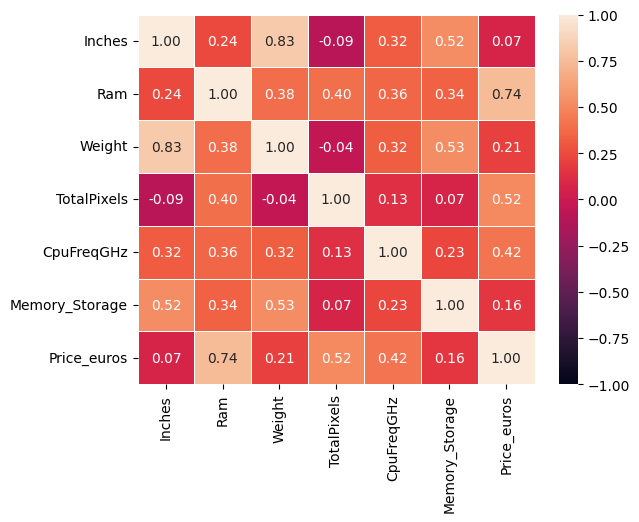

In [77]:
corr_matrix = regression_df[num_cols + ['Price_euros']].corr()
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    vmin=-1, vmax=1,
    linewidths=0.5
)

Можно заметить, что сильнее всего влияют на цену `Ram` и `TotalPixels`.

Поиск выбросов

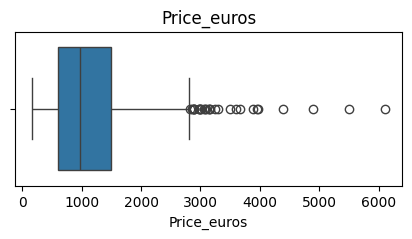

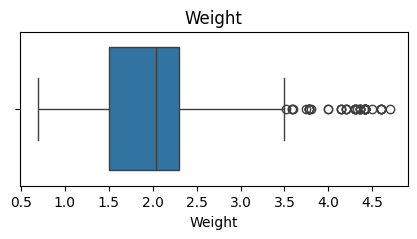

In [78]:
for col in ['Price_euros', 'Weight']:
    plt.figure(figsize=(5,2))
    sns.boxplot(x=regression_df[col])
    plt.title(col)


In [79]:
regression_df[regression_df['Price_euros'] > regression_df['Price_euros'].quantile(0.99)]

,laptop_ID,Company,Product,TypeName,Inches,Ram,OpSys,Weight,Price_euros,Touchscreen,IPS,RetinaDisplay,TotalPixels,CpuBrand,CpuSeries,CpuFreqGHz,Memory_Storage,Memory_Type,GpuBrand
196,200,Razer,Blade Pro,Gaming,17.3,32,Windows 10,3.49,6099.0,True,False,False,8294400,Intel,i7,2.9,1000,SSD,Nvidia
238,243,Asus,ROG G703VI-E5062T,Gaming,17.3,32,Windows 10,4.70,3890.0,False,False,False,2073600,Intel,i7,2.9,1512,SSD,Nvidia
610,617,Lenovo,Thinkpad P51,Notebook,15.6,32,Windows 10,2.50,4899.0,False,True,False,8294400,Intel,Xeon,3.1,1000,SSD,Nvidia
723,731,Dell,Alienware 17,Gaming,17.3,32,Windows 10,4.36,3659.4,False,False,False,8294400,Intel,i7,2.8,2000,SSD,Nvidia
744,752,Lenovo,Thinkpad P51s,Workstation,15.6,16,Windows 10,2.50,3299.0,False,True,False,8294400,Intel,i7,2.8,1000,SSD,Nvidia
749,758,HP,Zbook 17,Workstation,17.3,16,Windows 7,3.00,4389.0,False,True,False,2073600,Intel,Xeon,2.9,256,SSD,Nvidia
780,789,Dell,Alienware 17,Gaming,17.3,32,Windows 10,4.42,3588.8,False,True,False,2073600,Intel,i7,2.8,2000,SSD,Nvidia
830,839,Razer,Blade Pro,Gaming,17.3,32,Windows 10,3.49,5499.0,True,False,False,8294400,Intel,i7,2.9,512,SSD,Nvidia
955,969,Dell,Alienware 17,Gaming,17.3,16,Windows 10,4.36,3154.0,False,True,False,8294400,Intel,i7,2.8,1512,SSD,Nvidia
968,982,Dell,Alienware 17,Gaming,17.3,32,Windows 10,4.42,3149.0,False,True,False,2073600,Intel,i7,2.8,1256,SSD,Nvidia


In [80]:
regression_df[regression_df['Weight'] > regression_df['Weight'].quantile(0.99)]

,laptop_ID,Company,Product,TypeName,Inches,Ram,OpSys,Weight,Price_euros,Touchscreen,IPS,RetinaDisplay,TotalPixels,CpuBrand,CpuSeries,CpuFreqGHz,Memory_Storage,Memory_Type,GpuBrand
238,243,Asus,ROG G703VI-E5062T,Gaming,17.3,32,Windows 10,4.7,3890.00,False,False,False,2073600,Intel,i7,2.9,1512,SSD,Nvidia
577,584,Lenovo,IdeaPad Y910-17ISK,Gaming,17.3,32,Windows 10,4.6,2663.00,False,True,False,2073600,Intel,i7,2.7,1256,SSD,Nvidia
585,592,MSI,GT80S 6QE,Gaming,17.3,16,Windows 10,4.5,2349.00,False,False,False,2073600,Intel,i7,2.7,1128,SSD,Nvidia
1048,1062,Lenovo,IdeaPad Y900-17ISK,Gaming,17.3,16,Windows 10,4.6,2289.99,False,True,False,2073600,Intel,i7,2.6,1128,SSD,Nvidia
1081,1096,Lenovo,IdeaPad Y900-17ISK,Gaming,17.3,32,Windows 10,4.6,3240.00,False,True,False,2073600,Intel,i7,2.7,512,SSD,Nvidia
1116,1131,Lenovo,IdeaPad Y900-17ISK,Gaming,17.3,16,Windows 10,4.6,2749.99,False,True,False,2073600,Intel,i7,2.7,256,SSD,Nvidia


Тут нет ошибок данных, только реальные объекты, поэтому их удаление может негативно повлиять на точность модели в реальной задаче.

Подбор гиперпараметров с помощью `GridSearch`

In [81]:
pipeline = Pipeline((
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor()),
))

params = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    'regressor__n_neighbors': [3, 5, 7, 9, 11, 15],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(
    pipeline,
    params,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=True,
)
grid_search.fit(rX_train, ry_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


,estimator,Pipeline(step...Regressor())))
,param_grid,"{'preprocessor__num': [StandardScaler(), MinMaxScaler(), ...], 'regressor__metric': ['euclidean', 'manhattan', ...], 'regressor__n_neighbors': [3, 5, ...], 'regressor__weights': ['uniform', 'distance']}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('num', ...)]"


In [82]:
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший MAE:", -grid_search.best_score_)

# Лучший MAE: 196.92404862301532

Лучшие параметры: {'preprocessor__num': StandardScaler(), 'regressor__metric': 'manhattan', 'regressor__n_neighbors': 7, 'regressor__weights': 'distance'}
Лучший MAE: 196.92404862301532


In [83]:
ry_pred = grid_search.best_estimator_.predict(rX_test)
print(f"""
MAE:   {mean_absolute_error(ry_test, ry_pred)}
==============================
MAPE:   {mean_absolute_percentage_error(ry_test, ry_pred)}
RMSE:  {root_mean_squared_error(ry_test, ry_pred)}
""")


MAE:   187.48610305754687
MAPE:   0.16218547674293093
RMSE:  326.2344075913852



- MAE в обычном baseline: **213.7628735632184**
- MAE в улучшенном baseline: **187.48610305754687**

За счёт препроцессинга данных и подбора гиперпараметров удалось повысить точность модели

# Имплементация алгоритма KNN

Алгоритм *K-Nearest Neighbors* не строит явную модель, а принимает решение, сравнивая объект с обучающими параметрами по метрике расстояния.

Пусть есть обучающая выборка:
$$ \{(x_1, y_1), (x_2, y_2), ..., (x_n, y_n)\} $$
Тогда для вектора признаков $x_{new}$ значение $y_{new}$ выбирается следующим образом:
1. Рассчитывается расстояние от $x_{new}$ до всех $x_i$ из обучающей выборки. В качестве метрики может использоваться евклидово расстояние, манхэттенское расстояние и др.
2. Среди всех $x_i$ выбираются *K* ближайших.
3. Результат $y_{new}$ рассчитывается как среднее значение $y_i$ у *K* соседей или, в случае классификации, выбирается самый частый класс.


In [84]:
class KNearestNeighbors:
    def __init__(self, task: Literal['classification', 'regression'],
                 n_neighbors: int = 5,
                 metric: Literal['euclidean', 'manhattan'] = 'euclidean'):
        self._k = n_neighbors
        self._task = task
        self._metric = self._euclidean
        if metric == 'manhattan':
            self._metric = self._manhattan

    def fit(self, X, y):
        if hasattr(X, "toarray"):  # sparse
            self._train_X = X.toarray()
        elif isinstance(X, (pd.DataFrame, pd.Series)):
            self._train_X = X.to_numpy()
        else:
            self._train_X = np.array(X)

        if isinstance(y, (pd.DataFrame, pd.Series)):
            self._train_y = y.to_numpy().ravel()
        else:
            self._train_y = np.array(y).ravel()

    def _euclidean(self, a):
        return np.sqrt(np.sum((self._train_X - a)**2, axis=1))

    def _manhattan(self, a):
        return np.sum(np.abs(self._train_X - a), axis=1)

    def _predict_row(self, x):
        x = np.ravel(x)
        distances = self._metric(x)
        neighbors_idx = np.argpartition(distances, self._k)[:self._k]
        neighbors_y = self._train_y[neighbors_idx]
        if self._task == 'classification':
            best_value = max(set(neighbors_y),
                             key=list(neighbors_y).count)
        elif self._task == 'regression':
            best_value = neighbors_y.mean()
        else:
            raise ValueError("unknown task for KNN")
        return best_value

    def predict(self, X):
        if hasattr(X, "toarray"):
            X_arr = X.toarray()
        elif isinstance(X, (pd.DataFrame, pd.Series)):
            X_arr = X.to_numpy()
        else:
            X_arr = np.array(X)
        return np.array([self._predict_row(x) for x in X_arr])


## Испытание для задачи классификации

In [85]:
my_classifier = KNearestNeighbors('classification', n_neighbors=5)
my_classifier.fit(cX_train_scaled, cy_train)
cy_pred = my_classifier.predict(cX_test_scaled)
f1 = f1_score(cy_test, cy_pred)
print(f"F1 score for self-implemented KNN: {f1}")

F1 score for self-implemented KNN: 0.7219796215429404


Результат получился такой же как и в стандартном baseline.
Однако, самостоятельно написанный алгоритм работал
дольше аналогичного алгоритма из `sklearn`.

Осуществим подбор гиперпараметров, как в улучшенном baseline

In [86]:
def knn_grid_search(param_grid, X, y, scorer, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    best_score = None
    best_params = None
    results = []

    keys = list(param_grid.keys())
    for values in product(*param_grid.values()):
        params = dict(zip(keys, values))
        fold_scores = []
        for train_idx, val_idx in kf.split(X):
            X_train = X.iloc[train_idx] if hasattr(X, "iloc") else X[train_idx]
            X_val   = X.iloc[val_idx]   if hasattr(X, "iloc") else X[val_idx]
            y_train = y.iloc[train_idx] if hasattr(y, "iloc") else y[train_idx]
            y_val   = y.iloc[val_idx]   if hasattr(y, "iloc") else y[val_idx]

            model = KNearestNeighbors(**params)
            model.fit(X_train, y_train)
            preds = model.predict(X_val)

            fold_scores.append(scorer(y_val, preds))

        mean_score = np.mean(fold_scores)
        results.append({"params": params, "score": mean_score})

        if (best_score is None) or (mean_score > best_score):
            best_score = mean_score
            best_params = params

    return {
        "best_params": best_params,
        "best_score": best_score,
        # "results": results
    }

In [87]:
params = {
    'task': ['classification'],
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'metric': ['euclidean', 'manhattan']
}

knn_grid_search(params, cX_train_scaled, cy_train, f1_score)

{'best_params': {'task': 'classification',
  'n_neighbors': 15,
  'metric': 'manhattan'},
 'best_score': np.float64(0.733960867622754)}

In [88]:
my_classifier = KNearestNeighbors('classification',
                                  n_neighbors=15, metric='manhattan')
my_classifier.fit(cX_train_scaled, cy_train)
cy_pred = my_classifier.predict(cX_test_scaled)
f1 = f1_score(cy_test, cy_pred)
print(f"F1 score for self-implemented KNN: {f1}")

F1 score for self-implemented KNN: 0.7404214559386973


Результат стал немного хуже,
чем в улучшенном baseline при использовании алгоритма из `sklearn`.
Предположительно из-за использования взвешенного выбора класса (ближайшие соседи имеют больший вес, чем дальние).

## Испытание для задачи регрессии

In [89]:
my_regressor = KNearestNeighbors('regression', n_neighbors=5)
my_regressor.fit(rX_train_scaled, ry_train)
ry_pred = my_regressor.predict(rX_test_scaled)
mae = mean_absolute_error(ry_test, ry_pred)
print(f"MAE for self-implemented KNN: {mae}")

MAE for self-implemented KNN: 213.7628735632184


Результат такой же как и у алгоритма из `sklearn`

Подбор гиперпараметров для задачи регрессии

In [90]:
params = {
    'task': ['regression'],
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'metric': ['euclidean', 'manhattan']
}

knn_grid_search(params, rX_train_scaled, ry_train, lambda t, p: -mean_absolute_error(t, p))

{'best_params': {'task': 'regression',
  'n_neighbors': 7,
  'metric': 'manhattan'},
 'best_score': np.float64(-213.21180267758555)}

In [91]:
my_regressor = KNearestNeighbors('regression', n_neighbors=3,
                                 metric='euclidean')
my_regressor.fit(rX_train_scaled, ry_train)
ry_pred = my_regressor.predict(rX_test_scaled)
mae = mean_absolute_error(ry_test, ry_pred)
print(f"MAE for self-implemented KNN: {mae}")

MAE for self-implemented KNN: 208.00303959131546


Самостоятельно реализованный алгоритм снова отстаёт
от аналогичного из `sklearn`.

# Вывод

В ходе выполнения лабораторной работы был исследован алгоритм K ближайших соседей. Для задач классификации и регрессии были созданы обычный и улучшенный baseline.

Собственная реализация получила точность, немного хуже библиотечной.